<a href="https://colab.research.google.com/github/danielecaliari/AML/blob/main/modelli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras==2.3.1
%tensorflow_version 2.1.0
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from scipy import sparse


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/MyDrive/"
base_dir = root_dir + 'progetto_AML/'

Mounted at /content/drive


In [3]:

label = pd.read_csv(base_dir + 'label.csv')
label = label['price'].values

Regression without embeddings

In [4]:
from scipy import sparse
train = sparse.load_npz(base_dir + 'train.npz')
test = sparse.load_npz(base_dir + 'test.npz')


In [5]:
label.shape

(1481661,)

In [6]:
def create_mlp(dim):
	# define our MLP network
  model = Sequential()
  model.add(Dense(256, input_dim=dim, activation="relu"))
  model.add(Dense(128, activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(Dense(1, activation="linear"))
  return model

Split in training & validation

In [7]:
(train, validation, label_train, label_validation) = train_test_split(train , label , test_size=0.25, random_state=42)

In [8]:
validation

<370416x45811 sparse matrix of type '<class 'numpy.float64'>'
	with 12798615 stored elements in Compressed Sparse Row format>

In [9]:
train.shape[1]

45811

In [10]:
model = create_mlp(train.shape[1])
model.compile(loss="mean_squared_logarithmic_error")
model.fit(x=train, y=label_train, validation_data=(validation, label_validation), epochs=20, batch_size=128)

Epoch 1/20


ValueError: ignored

Prediction

In [ ]:
preds = model.predict(test)
# fare inversa log

Word embedding

In [11]:
train_emb = sparse.load_npz(base_dir + 'train_emb.npz')
test_emb = sparse.load_npz(base_dir + 'test_emb.npz')

In [12]:
train = pd.read_csv(base_dir + 'train.tsv', sep='\t')
test = pd.read_csv(base_dir + 'test.tsv', sep='\t')

In [13]:
train = train[train['price']>0].reset_index(drop=True)

In [14]:
train.item_description=train.item_description.astype(str)
test.item_description=test.item_description.astype(str)

In [15]:
train_names = train['name']
train_descriptions = train['item_description']

train_names_test = train['name']
train_descriptions_test = train['item_description']

In [16]:
(train_emb, validation_emb, label_train_emb, label_validation_emb) = train_test_split(train_emb , label , test_size=0.25, shuffle= False)
(train_names, train_names_validation) = train_test_split(train_names, test_size=0.25, shuffle= False)
(train_descriptions, train_descriptions_validation) = train_test_split(train_descriptions, test_size=0.25, shuffle= False)

In [ ]:
train_names

In [17]:
names = []
for n in train_names:
  names.append(n)

In [18]:
descriptions = []
for n in train_descriptions:
  descriptions.append(n)

In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=100000)
tokenizer.fit_on_texts(names)
sequences = tokenizer.texts_to_sequences(names)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

names_data = pad_sequences(sequences, maxlen=20)


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 100802 unique tokens.


In [20]:
tokenizer = Tokenizer(nb_words=100000)
tokenizer.fit_on_texts(descriptions)
sequences = tokenizer.texts_to_sequences(descriptions)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

descriptions_data = pad_sequences(sequences, maxlen=20)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 178020 unique tokens.


In [25]:
train_emb.shape

(1111245, 5811)

In [26]:
names_data.shape

(1111245, 20)

In [ ]:
train_emb.toarray()

In [44]:
from tensorflow import keras
num_words_name = 100802  # Size of vocabulary obtained when preprocessing text data
num_words_description = 178020  # Size of vocabulary obtained when preprocessing text data


name_input = keras.Input(shape=(None,), name="name")  # Variable-length sequence of ints
description_input = keras.Input(shape=(None,), name="description")  # Variable-length sequence of ints
other_features_input = keras.Input(shape=(None,train_emb.shape[1]), name="other_features_input")

# Embed each word in the title into a 64-dimensional vector
name_features = keras.layers.Embedding(num_words_name, 32)(name_input)
# Embed each word in the text into a 64-dimensional vector
description_features = keras.layers.Embedding(num_words_description, 64)(description_input)

#other_features_relu = keras.layers.Dense(128, activation="relu")(other_features_input)

# Merge all available features into a single large vector via concatenation
x = keras.layers.concatenate([name_features, description_features, other_features_input])


# Stick a logistic regression for priority prediction on top of the features
price_pred = keras.layers.Dense(1, activation="linear", name="price")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[name_input, description_input, other_features_input],
    outputs=[price_pred],
)

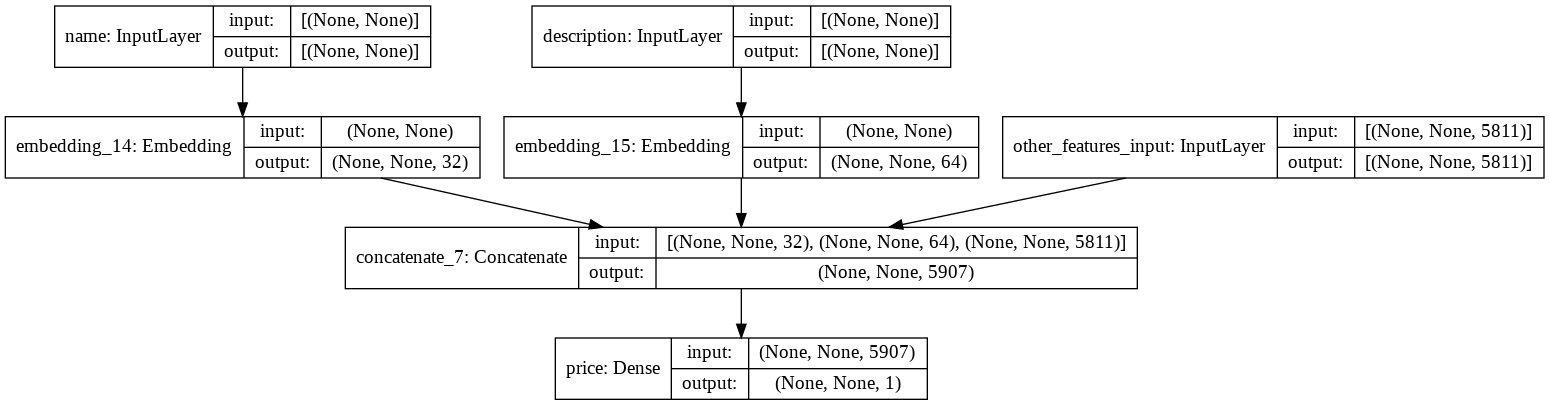

In [45]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [46]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "price": keras.losses.MeanSquaredLogarithmicError,
    },
    loss_weights=[1.0],
)

In [47]:
model.fit(
    {"name": names_data, "description": descriptions_data, "other_features_input": train_emb},
    {"price": label_train_emb},
    #validation_data=(train_names_validation, train_descriptions_validation, validation_emb, label_validation_emb),
    epochs=20,
    batch_size=128,
)

Epoch 1/20


ValueError: ignored

In [ ]:
!pip show keras